In [174]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
import matplotlib.pyplot as plt
from fuzzywuzzy import process

# Load crop production data
crop_df = pd.read_csv('Crop_Production_data.csv')

# ['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area', 'Production']

# Basic checks
print(f"Time range: {crop_df.Crop_Year.min()} - {crop_df.Crop_Year.max()}")
print(f"Districts: {crop_df.District_Name.nunique()}")
print(f"Missing values: \n {crop_df.isnull().sum()}")

Time range: 1997 - 2015
Districts: 644
Missing values: 
 State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64


In [175]:
# Load India districts shapefile (district boundries files)
gdf = gpd.read_file("map\IND_adm2.shp") 
states_gdf = gpd.read_file("map\IND_adm1.shp")

# function to Clean names in both the datasets and shap file
def clean_names(df, col):
    return df[col].str.strip().str.title()


# Modify the name of the districts from csv which won't match with shp file at all:
crop_df['State_Name'] = crop_df['State_Name'].replace('Uttarakhand','Uttaranchal')
crop_df['State_Name'] = crop_df['State_Name'].replace('Odisha','Orissa')
crop_df['District_Name'] = crop_df['District_Name'].replace('Y.S.R.','Cuddapah')
crop_df['District_Name'] = crop_df['District_Name'].replace('Purba Medinipur','East Midnapore')
crop_df['District_Name'] = crop_df['District_Name'].replace('Pashchim Medinipur','West Midnapore')
crop_df["District_Name"] = crop_df["District_Name"].replace('Bangalore', 'Bangalore URBAN')

# Clean the naming :
crop_df['State_Name'] = clean_names(crop_df, 'State_Name')
crop_df['District_Name'] = clean_names(crop_df, 'District_Name')
gdf['STATE'] = clean_names(gdf, 'NAME_1')        
gdf['District'] = clean_names(gdf, 'NAME_2')  

#gdf.head()

# Statistical overview of the data
crop_df.describe(include='all')

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
count,246091,246091,246091.000000,246091,246091,2.460910e+05,2.423610e+05
unique,33,644,NaN,8,126,NaN,NaN
top,Uttar Pradesh,Bijapur,NaN,Kharif,Rice,NaN,NaN
freq,33306,945,NaN,93584,15104,NaN,NaN
mean,NaN,NaN,2005.643018,NaN,NaN,1.200282e+04,5.825034e+05
std,NaN,NaN,4.952164,NaN,NaN,5.052340e+04,1.706581e+07
min,NaN,NaN,1997.000000,NaN,NaN,4.000000e-02,0.000000e+00
25%,NaN,NaN,2002.000000,NaN,NaN,8.000000e+01,8.800000e+01
50%,NaN,NaN,2006.000000,NaN,NaN,5.820000e+02,7.290000e+02
75%,NaN,NaN,2010.000000,NaN,NaN,4.392000e+03,7.023000e+03


In [176]:
## District Name macthing with shp file and corrections:

# Ref: i) https://www.datacamp.com/tutorial/fuzzy-string-python
#      ii) https://pathindependence.wordpress.com/2015/10/31/tutorial-fuzzywuzzy-string-matching-in-python-improving-merge-accuracy-across-data-products-and-naming-conventions/

## Identify Mismatches in Shap file Naming:
# Get unique state-district pairs from both datasets
df_districts = crop_df.groupby(['State_Name', 'District_Name']).size().reset_index()
shp_districts = gdf.groupby(['STATE', 'District']).size().reset_index()

# Find mismatches
mismatches = []
for idx, row in df_districts.iterrows():
    state = row['State_Name']
    district = row['District_Name']
    
    # Get matching districts from shapefile for this state
    shp_districts_for_state = shp_districts[shp_districts['STATE'] == state]['District'].tolist()
    
    if district not in shp_districts_for_state:
        mismatches.append({
            'State': state,
            'CSV_District': district,
            'Shapefile_Districts': shp_districts_for_state
        })

## Fuzzy Match Correction Suggestions ::

# Generate correction map
correction_map = {}
print("Suggested Corrections:")
for mismatch in mismatches:
    state = mismatch['State']
    csv_district = mismatch['CSV_District']
    candidates = mismatch['Shapefile_Districts']
    
    if candidates:
        match, score = process.extractOne(csv_district, candidates)
        if score > 70:  # 85 was giving much more mismatch
            # Add to correction map
            if state not in correction_map:
                correction_map[state] = {}
            correction_map[state][csv_district] = match
            
            # Print Correction :
            #print(f"{state}:")
            #print(f"  '{csv_district}' → '{match}' (confidence: {score}%)")

# Print the generated correction map
#print("\n Auto  Correction Map:")
#print(correction_map)        

# Update the dataframe with corrections
crop_df['District_Name'] = crop_df.apply(
    lambda x: correction_map.get(x['State_Name'], {}).get(x['District_Name'], x['District_Name']), 
    axis=1
)


Suggested Corrections:


In [ ]:
## Group District with state and distinct count to confirm mapping on shp file:

# Group districts with respective state to count the unique data point avialable:
district_counts = crop_df.groupby(['State_Name','District_Name'])['District_Name'].value_counts().reset_index()
district_counts.columns = ['State_Name','District_Name','Count']

# SHAP file data naming change to all captial letter
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper()  # State column in shapefile

# CSV file data naming change to all captial letter
district_counts['State_Name'] = district_counts['State_Name'].str.upper()
district_counts['District_Name'] = district_counts['District_Name'].str.strip().str.upper()

# merge data {csv and shap}:
merged_data = pd.merge(gdf,district_counts,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)


# Copy District with no data
unmerge_struct = merged_data[merged_data['Count'].isna()]


# Drop the districts with no count/data available:
merged_data.dropna(subset=['Count'], inplace=True)

ax = plt.figure(figsize=(10, 8))

base = gdf.plot(color='white', edgecolor='black')
merged_data.plot(ax=base, color='green', markersize=0.1)

# Overlay state boundaries
#states_gdf.boundary.plot(ax=base, color='black', linewidth=1.2)

plt.title('Matched Districts with Data Overview')
plt.show()


In [ ]:
# Creating charts for Total production Area
# Aggregate data count/occurance by district (example for latest year)
latest_year = crop_df['Crop_Year'].max()
year = 2009

# Mean over all years and seasons production area for each district    
District_Area = crop_df.groupby(['State_Name','District_Name'])['Area'].mean().reset_index()
District_Area.columns = ['State_Name','District_Name','Area']

# Mean of specific year and seasons production area for each district:
# District_Area = crop_df[crop_df['Crop_Year'] == year].groupby(['State_Name','District_Name'])['Area'].mean().reset_index()
# District_Area.columns = ['State_Name','District_Name','Area']

# SHAP file State and district naming change to all captial letter:
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper() 

# CSV file State and district naming change to all captial letter:
District_Area['State_Name'] = District_Area['State_Name'].str.upper()
District_Area['District_Name'] = District_Area['District_Name'].str.strip().str.upper()

merged_data = pd.merge(gdf,District_Area,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)

# Check District with no data/naming match (only for debug mismatched district):
#unmerge_struct = merged_data[merged_data['Area'].isna()]

# Fill zero for districts with no data available:
merged_data['Area'] = merged_data['Area'].fillna(0)

# Discretize Area into equal-sized bin based on sample quantiles
#merged_data['Area'] = pd.qcut(merged_data.Area,q=3,labels=["High", "Medium", "Low"])
merged_data['Area'] = pd.qcut(merged_data['Area'],q=10,duplicates='drop')

plt.figure(figsize=(12,12))

merged_data.plot(column='Area',cmap='RdBu_r', missing_kwds={'color': 'lightgrey'},linewidth=0.8, ax=plt.gca(), edgecolor='0.8',legend=True)
plt.title('District Crop Poduction Area Overview',fontsize=16)


plt.show()

In [ ]:
# Temporal trends for top crops :
# Filter for top 10 crops by production
top_crops = crop_df.groupby('Crop')['Production'].sum().nlargest(10).index
top_crops_data = crop_df[crop_df['Crop'].isin(top_crops)]

# scale the coconut production by 10 for better visualisation:
top_crops_data.loc[top_crops_data['Crop'].str.strip() == 'Coconut', 'Production'] = top_crops_data['Production'] / 10
grouped_data = top_crops_data.groupby(['Crop_Year', 'Crop'])['Production'].sum().unstack()
grouped_data.plot(figsize=(10, 8))
xlabel = 'Year'
ylabel = 'Production (in tons)'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(title='Crops', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
#change x axis ticks to every 2 years
plt.xticks(grouped_data.index[::2], rotation=45)
plt.tight_layout()
plt.title('Production Trends for Top 10 Crops')

#Count total distinct crops in the dataset
total_crops = crop_df['Crop'].nunique()

# Print the list of top crops by production rank
print(f"Top 10 Crops by Production (Out of total {total_crops} distinct crops in dataset):")
for i, crop in enumerate(top_crops, start=1):
    print(f"{i}. {crop}")



In [ ]:
# Top production state as bar plot
top_production_state = crop_df.groupby('State_Name')['Production'].sum().nlargest(10)
top_production_state.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 10 States by Total Production')
plt.xlabel('State')
plt.ylabel('Total Production')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# Top yield state overall as bar plot

# Fill zero for the state district with missing production value:
crop_df['Production'] = crop_df['Production'].fillna(0)

top_yield_state = crop_df.groupby('State_Name')['Production'].sum() / crop_df.groupby('State_Name')['Area'].sum()
top_yield_state = top_yield_state.nlargest(10)
top_yield_state.plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Top 10 States by Yield (Production per Area)')
plt.xlabel('State')
plt.ylabel('Yield (Production per Area)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
#ref:
# [1] https://darribas.org/gds_scipy16/ipynb_md/04_esda.html
# [2] https://sergerey.org/385f24/lectures/week06/spatial_weights.html#/imports
# [3] https://spatialanalysis.github.io/handsonspatialdata/contiguity-based-spatial-weights.html

# Aggregate data count/occurance by district (example for latest year)
latest_year = crop_df['Crop_Year'].max()
year = 1997

# District data count :
district_counts = crop_df.groupby(['State_Name','District_Name'])['District_Name'].value_counts().reset_index()
district_counts.columns = ['State_Name','District_Name','Count']

# district_counts = crop_df[crop_df['Crop_Year'] == year].groupby(['State_Name','District_Name'])['District_Name'].value_counts().reset_index()
# district_counts.columns = ['State_Name','District_Name','Count']

# SHAP file data naming change to all captial letter
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper() 

# CSV file data naming change to all captial letter
district_counts['State_Name'] = district_counts['State_Name'].str.upper()
district_counts['District_Name'] = district_counts['District_Name'].str.strip().str.upper()


# Drop all data from structure
merged_data.iloc[:0]

# Merge production data with spatial data
merged_data = pd.merge(gdf,district_counts,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)

#merged = gdf.merge(district_counts, how='left', left_on='DISTRICT', right_on='District_Name')

# Drop the districts with no count/data available:
# Define exception conditions 
# District to exclude from NaN filtering
exception_district = ['GILGIT', 'AKSAI CHIN']

# Filter: keep rows where 'count' is not NaN, or where 'state' is in exception_states
#merged_data = merged_data[(~merged_data['Count'].isna()) | (merged_data['District'].isin(exception_district))]


# Create spatial weights matrix (Contiguity-Based Spatial Weights) [3] 
# Contiguity means that two spatial units share a common border of non-zero length.
# In order to deal with potential inaccuracies in the polygon file (such as rounding errors),
# using the queen criterion is recommended in practice. Hence it is also the default for contiguity weights.
w = Queen.from_dataframe(merged_data)
Wmatrix, ids = w.full()
#print(Wmatrix)

n_neighbors = Wmatrix.sum(axis=1) # how many neighbors each region has [2]

# Add new coloumn with number of neighbour count
merged_data['Neighbors_Count'] = n_neighbors


# Calculate Moran's I for spatial autocorrelation
moran = Moran(merged_data['Neighbors_Count'].fillna(0), w)

print(f"\nMoran's I stats based on number of neighbors: \n")
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_norm}")

#Evaluate Morans I stats for hypthesis testing:
# H0: There is no spatial autocorrelation in the data.
# H1: There is spatial autocorrelation in the data.
# If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is significant spatial autocorrelation in the data.
# If the p-value is greater than the significance level, we fail to reject the null hypothesis and conclude that there is no significant spatial autocorrelation in the data.
print(f"\nHypothesis Testing:")
if moran.p_norm < 0.05:
    print("Reject the null hypothesis: There is significant spatial autocorrelation in the data.")
else:
    print("Fail to reject the null hypothesis: There is no significant spatial autocorrelation in the data.")


# Create a figure with two subplots in one row
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

# Plot each GeoDataFrame on its respective axis
merged_data.plot(ax=ax1, column='Neighbors_Count', legend=False,legend_kwds={'label': "District data Count"},cmap='RdBu_r', missing_kwds={'color': 'lightgrey'})
#overlay state boundaries
ax1.set_title('Overall District Data Count distribution')


merged_data.plot(ax=ax2, column='Neighbors_Count', legend=False,legend_kwds={'label': "District data Count"},cmap='RdBu_r', missing_kwds={'color': 'lightgrey'})
# merged_data['Neighbors_Count'] = pd.qcut(merged_data['Neighbors_Count'],q=14,duplicates='raise')
# merged_data.plot(ax=ax2, column='Neighbors_Count', legend=True,cmap='RdBu_r', missing_kwds={'color': 'lightgrey'})
#overlay state boundaries
#states_gdf.boundary.plot(ax=plt.gca(), color='green', linewidth=0.5)
ax2.set_title('Overall District Data Count distribution')

# plt.tight_layout()
# plt.show()

#YlGn
#RdYlGn_r

      

C:\Users\uidk7429\AppData\Local\Temp\ipykernel_22204\1525530322.py:35: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged_data)
d:\STPD\.venv\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 5 islands with ids: 0, 1, 246, 594, 595.
  warnings.warn(message)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 246, ' is an island (no neighbors)')
('WARNING: ', 594, ' is an island (no neighbors)')
('WARNING: ', 595, ' is an island (no neighbors)')

Hypothesis Testing:
Reject the null hypothesis: There is significant spatial autocorrelation in the data.
Moran's I: 0.5206577420647196
P-value: 3.8291134468880114e-91


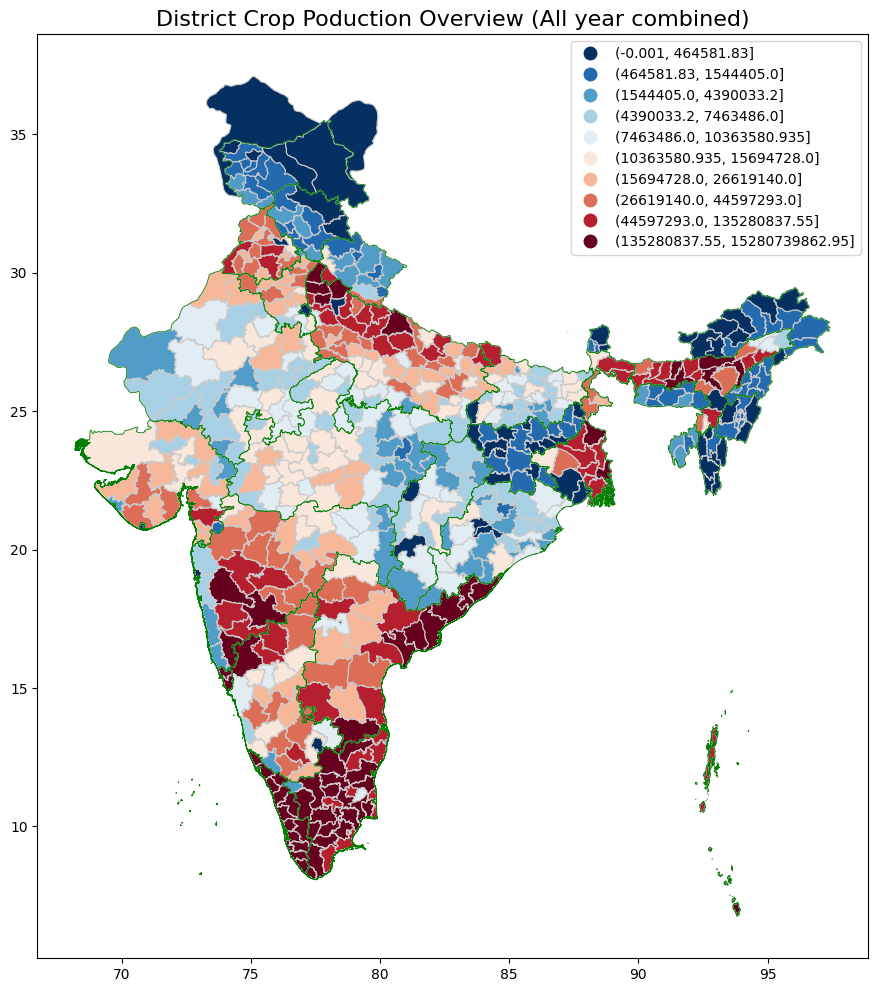

In [177]:
# Creating charts for Total production 
# Aggregate data count/occurance by district (example for latest year)
latest_year = crop_df['Crop_Year'].max()
year = 2009

# Mean over all years and seasons production for each district    
District_Production = crop_df.groupby(['State_Name','District_Name'])['Production'].sum().reset_index()
District_Production.columns = ['State_Name','District_Name','Production']

# Mean of specific year and seasons production for each district:
# District_Production = crop_df[crop_df['Crop_Year'] == year].groupby(['State_Name','District_Name'])['Production'].mean().reset_index()
# District_Production.columns = ['State_Name','District_Name','Production']

# SHAP file State and district naming change to all captial letter:
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper() 

# CSV file State and district naming change to all captial letter:
District_Production['State_Name'] = District_Production['State_Name'].str.upper()
District_Production['District_Name'] = District_Production['District_Name'].str.strip().str.upper()

merged_data = pd.merge(gdf,District_Production,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)

# Check District with no data/naming match (only for debug mismatched district):
#unmerge_struct = merged_data[merged_data['Production'].isna()]

# Fill zero for districts with no data available:
merged_data['Production'] = merged_data['Production'].fillna(0)

# Create spatial weights matrix (Contiguity-Based Spatial Weights)
# Contiguity means that two spatial units share a common border of non-zero length.
# In order to deal with potential inaccuracies in the polygon file (such as rounding errors),
# using the queen criterion is recommended in practice. Hence it is also the default for contiguity weights.
w = Queen.from_dataframe(merged_data)
Wmatrix, ids = w.full()
#print(Wmatrix)

n_neighbors = Wmatrix.sum(axis=1) # how many neighbors each region has [2]

# Add new coloumn with number of neighbour count
merged_data['Neighbors_Count'] = n_neighbors


# Calculate Moran's I for spatial autocorrelation
moran = Moran(merged_data['Production'].fillna(0), w)

print(f"\nHypothesis Testing:")
if moran.p_norm < 0.05:
    print("Reject the null hypothesis: There is significant spatial autocorrelation in the data.")
else:
    print("Fail to reject the null hypothesis: There is no significant spatial autocorrelation in the data.")

print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_norm}")

# Discretize Production into equal-sized bin based on sample quantiles
#merged_data['Production'] = pd.qcut(merged_data.Production,q=3,labels=["High", "Medium", "Low"])
merged_data['Production'] = pd.qcut(merged_data['Production'],q=10,duplicates='drop')

plt.figure(figsize=(12,12))

merged_data.plot(column='Production',cmap='RdBu_r', missing_kwds={'color': 'lightgrey'},linewidth=0.8, ax=plt.gca(), edgecolor='0.8',legend=True)
plt.title('District Crop Poduction Overview (All year combined)',fontsize=16)

#overlay state boundaries
states_gdf.boundary.plot(ax=plt.gca(), color='green', linewidth=0.5)


plt.show()

In [ ]:
# Seasonal production patterns
# ['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area', 'Production']
# Strip any extra whitespace from the 'Season' column to ensure consistency
crop_df['Season'] = crop_df['Season'].str.strip()

# Get unique seasons
season = crop_df['Season'].unique()
print(f'Types of season: {season}')

# Filter for top 10 crops by production
seasonal = crop_df.groupby(['Season','Crop'])['Production'].mean().nlargest(15).reset_index()

#scale the coconut production by 10 for better visualisation:
seasonal.loc[seasonal['Crop'].str.strip() == 'Coconut', 'Production'] = seasonal['Production'] / 40
#seasonal.loc[seasonal['Crop'].str.strip() == 'Oilseeds total', 'Production'] = seasonal['Production'] / 10
#seasonal.loc[seasonal['Crop'].str.strip() == 'Sugarcane', 'Production'] = seasonal['Production'] / 10

#Print the crop with maximum production in each season:
for s in seasonal['Season'].unique():
    max_crop = seasonal[seasonal['Season'] == s].sort_values(by='Production', ascending=False).iloc[0]
    print(f"Season: {s}, Crop: {max_crop['Crop']}, Production: {max_crop['Production']}")

# plot the seasonal production patterns
seasonal_pivot = seasonal.pivot(index='Season', columns='Crop', values='Production')

seasonal_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Seasonal Production Patterns for Different Crops')
plt.xlabel('Season')
plt.ylabel('Average Production')
plt.xticks(rotation=0)
# limit the yaxis to 0-1000000 for better visualisation
plt.ylim(0, 1750000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Crops', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
from esda.moran import Moran_Local


# Mean over all years and seasons production for each district    
District_Production = crop_df.groupby(['State_Name','District_Name'])['Production'].sum().reset_index()
District_Production.columns = ['State_Name','District_Name','Production']

# Mean of specific year and seasons production for each district:
# District_Production = crop_df[crop_df['Crop_Year'] == year].groupby(['State_Name','District_Name'])['Production'].mean().reset_index()
# District_Production.columns = ['State_Name','District_Name','Production']

# SHAP file State and district naming change to all captial letter:
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper() 

# CSV file State and district naming change to all captial letter:
District_Production['State_Name'] = District_Production['State_Name'].str.upper()
District_Production['District_Name'] = District_Production['District_Name'].str.strip().str.upper()

merged_data = pd.merge(gdf,District_Production,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)

# Calculate Local Moran's I for spatial autocorrelation
# Create spatial weights matrix (Contiguity-Based Spatial Weights)
# Contiguity means that two spatial units share a common border of non-zero length.
# In order to deal with potential inaccuracies in the polygon file (such as rounding errors),

# using the queen criterion is recommended in practice. Hence it is also the default for contiguity weights.
w = Queen.from_dataframe(merged_data)

Wmatrix, ids = w.full()
#print(Wmatrix)

n_neighbors = Wmatrix.sum(axis=1) # how many neighbors each region has [2]

# Add new coloumn with number of neighbour count
merged_data['Neighbors_Count'] = n_neighbors

# Calculate Local Moran's I for spatial autocorrelation
rice_df = merged_data.copy()
rice_df = rice_df[rice_df['Crop'] == 'Rice']

rice_df = rice_df[rice_df['Production'] > 0]
rice_df = rice_df[rice_df['Area'] > 0]

# Calculate Local Moran's I for spatial autocorrelation
lisa = Moran_Local(rice_df.Production, w)
sig = lisa.p_sim < 0.05
print(f"Hotspots: {sum(lisa.q==1 & sig)}\nColdspots: {sum(lisa.q==3 & sig)}")


C:\Users\uidk7429\AppData\Local\Temp\ipykernel_22204\2164363033.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  districts_centroid['centroid'] = districts_centroid.geometry.centroid
d:\STPD\.venv\lib\site-packages\scipy\sparse\_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


1: ANDAMAN ISLANDS (ANDAMAN AND NICOBAR)
2: NICOBAR ISLANDS (ANDAMAN AND NICOBAR)
3: ANANTAPUR (ANDHRA PRADESH)
4: CHITTOOR (ANDHRA PRADESH)
5: CUDDAPAH (ANDHRA PRADESH)
6: EAST GODAVARI (ANDHRA PRADESH)
7: GUNTUR (ANDHRA PRADESH)
8: KRISHNA (ANDHRA PRADESH)
9: KURNOOL (ANDHRA PRADESH)
10: NELLORE (ANDHRA PRADESH)
11: PRAKASAM (ANDHRA PRADESH)
12: SRIKAKULAM (ANDHRA PRADESH)
13: VISHAKHAPATNAM (ANDHRA PRADESH)
14: VIZIANAGARAM (ANDHRA PRADESH)
15: WEST GODAVARI (ANDHRA PRADESH)
16: CHANGLANG (ARUNACHAL PRADESH)
17: EAST KAMENG (ARUNACHAL PRADESH)
18: EAST SIANG (ARUNACHAL PRADESH)
19: KURUNG KUMEY (ARUNACHAL PRADESH)
20: LOHIT (ARUNACHAL PRADESH)


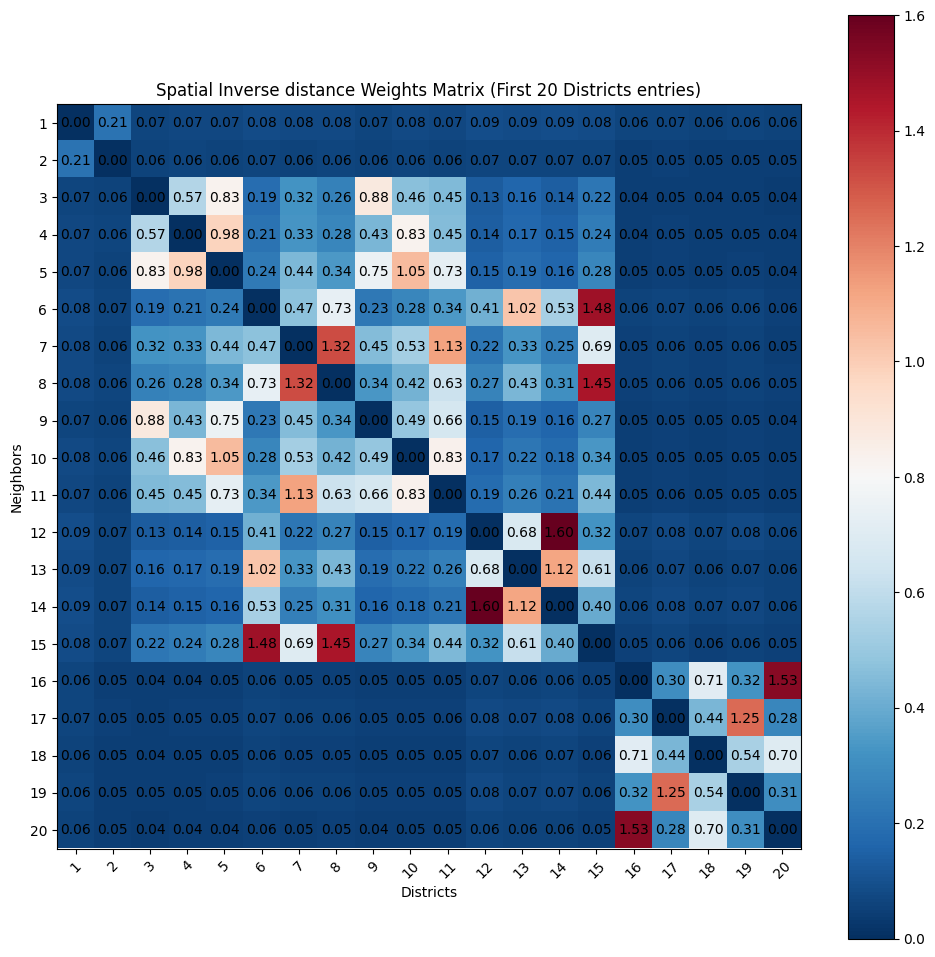

In [211]:
from scipy.spatial.distance import pdist, squareform
from libpysal.weights import DistanceBand, lag_spatial


districts_centroid = merged_data #.groupby(['STATE', 'District']).geometry.first().reset_index()

# Calculate centroids
districts_centroid['centroid'] = districts_centroid.geometry.centroid

# Extract coordinates
coords = [(point.x, point.y) for point in districts_centroid['centroid']]

# Create a spatial weights matrix using DistanceBand (distancein meters)
# The threshold in DistanceBand refers to the critical distance (also called the distance band or cutoff distance)
# used to define which observations are considered neighbors in a spatial weights matrix
w = DistanceBand(coords, threshold=10000000, binary=False, silence_warnings=True)

# Inverse Distanace Weight Matrix:
Wmatrix, ids = w.full()
# Below Matrix plot showing how inverse matrix usefull for spatial autocorrelation by weighting neighboring observations 
# The inverse distance weight matrix W assigns higher weights to closer neighbors and lower weights to distant ones

plt.figure(figsize=(12, 12))

No_of_entries = 20
plt.imshow(Wmatrix[:No_of_entries, :No_of_entries], cmap='RdBu_r')
plt.title(f'Spatial Inverse distance Weights Matrix (First {No_of_entries} Districts entries)')
plt.xlabel('Districts')
plt.ylabel('Neighbors')
# plot Wmatrix value in each box as well
for i in range(No_of_entries):
    for j in range(No_of_entries):
        plt.text(j, i, f"{Wmatrix[i, j]:.2f}", ha='center', va='center', color='black')
# print first 10 district name from districts_centroid with indexing:
for i, district in enumerate(districts_centroid['District'].unique()[:No_of_entries], start=1):
    state = districts_centroid[districts_centroid['District'] == district]['STATE'].iloc[0]
    print(f"{i}: {district} ({state})")

plt.xticks(range(No_of_entries), districts_centroid['District'].unique()[:No_of_entries], rotation=45)
plt.xticks(range(No_of_entries), range(1, No_of_entries+1))
plt.yticks(range(No_of_entries), range(1, No_of_entries+1))
plt.colorbar()
plt.show()

# # Calculate Moran's I for spatial autocorrelation
# moran = Moran(merged_data['Production'].fillna(0), w)

# print(f"\nHypothesis Testing:")
# if moran.p_norm < 0.05:
#     print("Reject the null hypothesis: There is significant spatial autocorrelation in the data.")
# else:
#     print("Fail to reject the null hypothesis: There is no significant spatial autocorrelation in the data.")

# print(f"Moran's I: {moran.I}")
# print(f"P-value: {moran.p_norm}")

# # Spatial lag vs production
# spatial_lag = lag_spatial(w, districts_centroid["Production"])
# plt.scatter(districts_centroid["Production"], spatial_lag)
# plt.xlabel("Production")
# plt.ylabel("Spatially Lagged Production")
# plt.title("Moran Scatterplot")

1: ANDAMAN ISLANDS (ANDAMAN AND NICOBAR)
2: NICOBAR ISLANDS (ANDAMAN AND NICOBAR)
3: ANANTAPUR (ANDHRA PRADESH)
4: CHITTOOR (ANDHRA PRADESH)
5: CUDDAPAH (ANDHRA PRADESH)
6: EAST GODAVARI (ANDHRA PRADESH)
7: GUNTUR (ANDHRA PRADESH)
8: KRISHNA (ANDHRA PRADESH)
9: KURNOOL (ANDHRA PRADESH)
10: NELLORE (ANDHRA PRADESH)


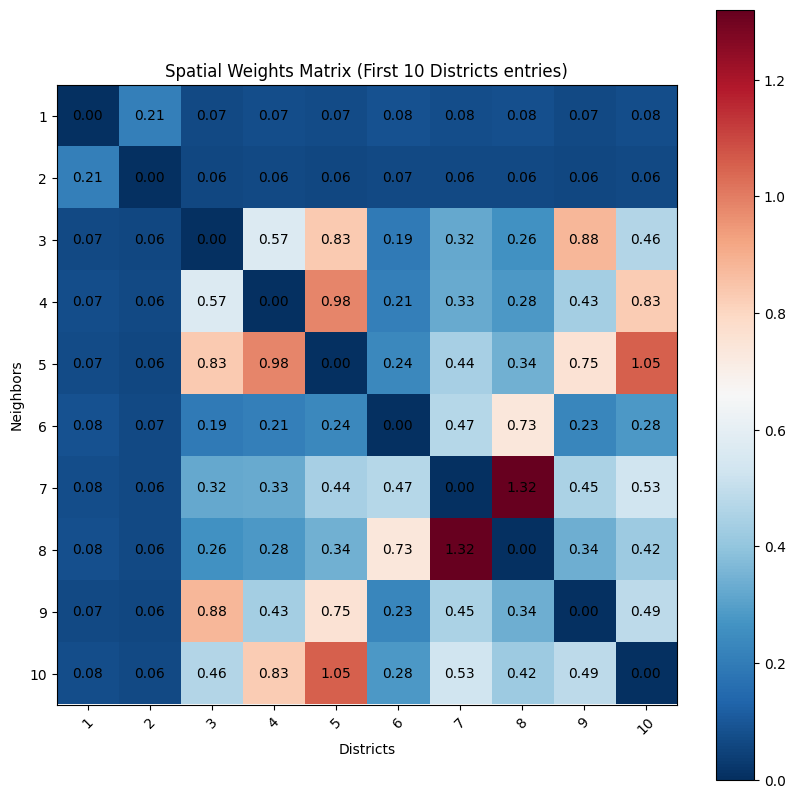